In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.neighbors import KernelDensity
import warnings
warnings.filterwarnings("ignore")

In [35]:
df = pd.read_csv('d17008_Iqbal_pdf.csv')#'kartal.csv'
df = df.sort_values(by='Item', ascending=True)
df.index = df['Item'].values
del df['Item']
df.head()

,Annual\nRequirement,Average\nUnit\nCost\n(Dollars),Lead\nTime\n(Weeks)
1,44460,39.25,12
2,89600,2.49,12
3,28200,81.45,6
4,113544,25.32,6
5,20400,38.10,12


C    65
B    28
A     7
Name: Class, dtype: int64

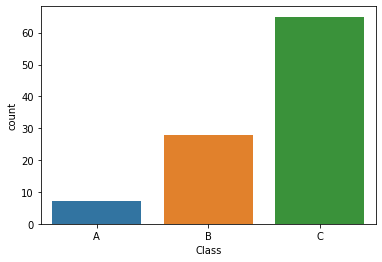

In [52]:
le = preprocessing.LabelEncoder()

nb = pd.DataFrame({
    "V+": np.zeros(len(df.columns)), # ideal best
    "V-": np.zeros(len(df.columns))  # ideal worst
}).T

dff = df.copy()
d_f = df.copy()
dff.head()

w = [.4,.4,.2]

for i in range(len(df.columns)):
    dff.iloc[:,i] = (df.iloc[:,i] / np.sqrt(( df.iloc[:,0] ** 2 ).sum())) * w[i]
    if i == 1 or i == 2: # non-benificial, lower value is desired, lower value is ideal best, higher value is ideal worst
        
        nb.iloc[0,i] = dff.iloc[:,i].min() #non-benificial - lower value ideal best
        nb.iloc[1,i] = dff.iloc[:,i].max() #non-benificial - higher value ideal worst
        
        
    else:                   # benificial, higher value is desired, higher value is ideal best, lower value is ideal worst
        
        nb.iloc[0,i] = dff.iloc[:,i].max() #benificial - higher value ideal best
        nb.iloc[1,i] = dff.iloc[:,i].min() #benificial - lower value ideal worst

nb.columns = df.columns

temp1 = dff.copy()
temp2 = dff.copy()

for i in range(len(df.columns)):
    temp1.iloc[:,i] = (temp1.iloc[:,i] - nb.iloc[0,i]) ** 2
    

for i in range(len(df.columns)):
    temp2.iloc[:,i] = (temp1.iloc[:,i] - nb.iloc[1,i]) ** 2
    

dff['S+'] = 0
dff['S-'] = 0

for i in range(len(df)):
    dff.iloc[i,-2] = np.sqrt(temp1.iloc[i,:].sum(axis = 0))
    dff.iloc[i,-1] = np.sqrt(temp2.iloc[i,:].sum(axis = 0))


dff['S+ + S-'] = 0
dff['p'] = 0

dff['S+ + S-'] = dff['S+'] + dff['S-']

dff['p'] = dff['S-'] / dff['S+ + S-']

d_f['p'] = dff['p']
d_f = d_f.sort_values(by='p', ascending=False) # heighest P value has the top rank

d_f['RunCumCost'] = d_f['p'].cumsum()
TotSum = d_f['p'].sum()
d_f['RunCostPerc'] = (d_f['RunCumCost']/TotSum)*100

def ABC_segmentation(perc):

#top A - top 20%, C - last 50% and B - between A & C

    if perc <=20 :
        return 'A'
    elif perc > 20 and perc < 50:
        return 'B'
    elif perc >= 50:
        return 'C'
    
d_f['Class'] = d_f['RunCostPerc'].apply(ABC_segmentation)
ax = sns.countplot(x = d_f['Class'],data = d_f,label= 'Count')

d_f['Class'].value_counts()

In [53]:
d_f.head(5)

,Annual\nRequirement,Average\nUnit\nCost\n(Dollars),Lead\nTime\n(Weeks),p,RunCumCost,RunCostPerc,Class
9,120000,2.21,8,0.999460,0.999460,10.388953,A
4,113544,25.32,6,0.361763,1.361222,14.149321,A


In [61]:
X = d_f.iloc[:,0:3].copy()
y = d_f.iloc[:,-1].copy()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [106]:
model = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p=2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("********KNN********")
print("test acc: ",accuracy_score(y_test, y_pred))
print("train acc: ",accuracy_score(y_train, model.predict(X_train)))

********KNN********
test acc:  0.98
train acc:  0.9971428571428571


In [107]:
model = SVC(kernel = 'poly')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("********SVC********")
print("train acc: ",accuracy_score(y_train, model.predict(X_train)))
print("test acc: ",accuracy_score(y_test, y_pred))

********SVC********
train acc:  0.7342857142857143
test acc:  0.6866666666666666


# Random Over Sampling

In [149]:
sampling_strategy = {0: 20*10, 1:30*10, 2:50*10}
X_res, y_res = RandomOverSampler(sampling_strategy = sampling_strategy).fit_resample(d_f.iloc[:,0:3], \
                                                                                     le.fit_transform(d_f['Class']))

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [150]:
modelKNN = KNeighborsClassifier(n_neighbors = 3, p =1)#, metric = 'minkowski', p=2)
modelKNN.fit(X_train, y_train)
y_pred = modelKNN.predict(X_test)

scores = cross_val_score(modelKNN, X_train, y_train, cv=10)
print("********KNN********")
print("train acc: ",accuracy_score(y_train, modelKNN.predict(X_train)))
print("test acc: ",accuracy_score(y_test, y_pred))
print("cv score: ",scores.mean())

********KNN********
train acc:  1.0
test acc:  1.0
cv score:  1.0


In [151]:
modelSVC = SVC(kernel = 'poly')
modelSVC.fit(X_train, y_train)
y_pred = modelSVC.predict(X_test)
scores = cross_val_score(modelSVC, X_train, y_train, cv=10)
print("********SVC********")
print("train acc: ",accuracy_score(y_train, modelSVC.predict(X_train)))
print("test acc: ",accuracy_score(y_test, y_pred))
print("cv score: ",scores.mean())

********SVC********
train acc:  0.69125
test acc:  0.72
cv score:  0.6875000000000001


In [154]:
d_f.to_csv("Classed.csv")

In [156]:
dff.to_csv("TopsisData")

In [157]:
nb

,Annual\nRequirement,Average\nUnit\nCost\n(Dollars),Lead\nTime\n(Weeks)
V+,0.151502,0.000003,0.000003
V-,0.004681,0.000216,0.000010
